# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Load-Data" data-toc-modified-id="Load-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Data</a></div><div class="lev1 toc-item"><a href="#Word-Segmentation" data-toc-modified-id="Word-Segmentation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Word Segmentation</a></div><div class="lev1 toc-item"><a href="#Tokenize-Text" data-toc-modified-id="Tokenize-Text-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Tokenize Text</a></div><div class="lev1 toc-item"><a href="#Load-Model" data-toc-modified-id="Load-Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load Model</a></div><div class="lev2 toc-item"><a href="#Set-Hyperparameters" data-toc-modified-id="Set-Hyperparameters-41"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Set Hyperparameters</a></div><div class="lev2 toc-item"><a href="#Import-Libraries" data-toc-modified-id="Import-Libraries-42"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Import Libraries</a></div><div class="lev2 toc-item"><a href="#Build-Graph" data-toc-modified-id="Build-Graph-43"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Build Graph</a></div><div class="lev2 toc-item"><a href="#Load-Weights" data-toc-modified-id="Load-Weights-44"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Load Weights</a></div>

# Load Data

In [3]:
import json
import os

In [4]:
def load_data(path, name):
    """
    Load date from file
    """
    data = []
    input_file = os.path.join(path)
    with open(input_file) as f:
        lines = f.readlines()
    for line in lines:
        item = json.loads(line)
        data.append(item[name])
    return data

def add_token(s):
    """
    Add end token
    """
    s = s.split()
    n = []
    for i in s:
        if i.endswith('.') or i.endswith('!') or i.endswith('?'):
            i += 'endtok'
        n.append(i)
    return ' '.join(n)

In [6]:
devSent1 = load_data('/Users/lizhn7/Downloads/EXPERIMENT/COPA/LM/data/copa-dev.json', 'whole-sentence1')
devSent1 = [add_token(c) for c in devSent1]
devSent2 = load_data('/Users/lizhn7/Downloads/EXPERIMENT/COPA/LM/data/copa-dev.json', 'whole-sentence2')
devSent2 = [add_token(c) for c in devSent2]

In [162]:
label = load_data('/Users/lizhn7/Downloads/EXPERIMENT/COPA/LM/data/copa-dev.json', 'most-plausible-alternative')
label = [int(l) for l in label]

# Word Segmentation

In [10]:
from nltk import regexp_tokenize
from nltk import WordNetLemmatizer
import numpy as np
from tqdm import tqdm

In [58]:
replDict = {'tattled': 'tattle', 'shirtsleeve': 'shirtsleeves', 'pruny': 'prune', 
            'dry-cleaned': 'dry-clean', 'illegibly': 'illegible', 'unlaced': 'untie'}

In [59]:
def cut(s):
    """
    Word segmentation
    """
    pattern = r'''
              (?x)                   # set flag to allow verbose regexps 
              (?:[A-Z]\.)+           # abbreviations, e.g. U.S.A. 
              |\w+(?:[-&']\w+)*      # words w/ optional internal hyphens/apostrophe  
            '''  
    return regexp_tokenize(s, pattern=pattern)

def clean(s):
    """
    Clean data
    """
    for i in range(len(s)):
        for d in ['0', '1', '2', '3', '4', '5' ,'6', '7', '8', '9']:
            if d in s[i]:
                s[i] = '0'
        if s[i] == 'p' and i < len(s)-1:
            if s[i+1] == 'm':
                s[i] = 'pm'
                s[i+1] = ''
        if s[i] == 'a' and i < len(s)-1:
            if s[i+1] == 'm':
                s[i] = 'am'
                s[i+1] = ''
        if s[i] == 's':
            s[i] = ''
        if s[i].endswith("'s"):
            s[i] = s[i][:-2]
    s = [i for i in s if i != '']
    return [replDict.get(i.lower(), i.lower()) for i in s]

In [60]:
devWord1 = [clean(cut(s)) for s in devSent1]
devWord2 = [clean(cut(s)) for s in devSent2]

#  Tokenize Text

In [62]:
import pickle

In [63]:
with open('/Users/lizhn7/Downloads/EXPERIMENT/COPA/LM/data/index.pkl', 'rb') as fp:
    word2index, index2word, glove_index2index = pickle.load(fp)

In [64]:
NUM_GRAMS = 25
NUM_UNK_WORDS = 5
VOCAB_SIZE = 20000

In [65]:
for i in range(NUM_UNK_WORDS):
    index2word[VOCAB_SIZE-1-i] = '<%d>'%i

unk0 = VOCAB_SIZE - NUM_UNK_WORDS

In [112]:
index2word[19999]

'<0>'

In [66]:
def vocab_fold(xs):
    """
    Convert list of word indexes that may contain words outside vocab_size to words inside.
    If a word is outside, try first to use glove_idx2idx to find a similar word inside.
    If none exist then replace all accurancies of the same unknown word with <0>, <1>, ...
    """
    xs = [x if x < unk0 else glove_index2index.get(x, x) for x in xs]
    # the more popular word is <0> and so on
    outside = sorted([x for x in xs if x >= unk0])
    # if there are more than unknown_words unk words then put them all in unknown_words-1
    outside = {x: VOCAB_SIZE-1-min(i, NUM_UNK_WORDS-1) for i, x in enumerate(outside)}
    xs = [outside.get(x, x) for x in xs]
    return xs

In [77]:
devSeq1 = [[word2index.get(w, w) for w in s] for s in devWord1]
devSeq1 = [vocab_fold(s) for s in devSeq1]
devSeq2 = [[word2index.get(w, w) for w in s] for s in devWord2]
devSeq2 = [vocab_fold(s) for s in devSeq2]

# Load Model

## Set Hyperparameters

In [78]:
NUM_GRAMS = 25
NUM_UNK_WORDS = 5
VOCAB_SIZE = 20000
EMBEDDING_DIM = 200
BATCH_SIZE = 1024
NUM_EPOCHS = 2
RNN_SIZE = 1024

## Import Libraries

In [79]:
from keras.layers import Input, Embedding, LSTM, Dense, Dropout
from keras.models import Model
import keras.backend as K
from keras.callbacks import*
import numpy as np
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Using TensorFlow backend.


## Build Graph

In [81]:
import h5py

In [82]:
with h5py.File('/Users/lizhn7/Downloads/EXPERIMENT/COPA/LM/data/embedding.h5', 'r') as fh:
    embedding = fh['embedding'][:]

In [243]:
K.clear_session()
# Encoder
inputs = Input(shape=(None,), name='EN_INPUT', dtype='int64')
emb_seq = Embedding(VOCAB_SIZE, 
                    EMBEDDING_DIM, 
                    weights=[embedding], 
                    mask_zero=True, 
                    trainable=True, 
                    name='EN_EMBEDDING')(inputs)
lstm = LSTM(RNN_SIZE, return_sequences=False, implementation=0, name='EN_LSTM')(emb_seq)
encoder = Model(inputs=inputs, outputs=lstm)

# Language Model
input_grams = Input(shape=(NUM_GRAMS,), name='LM_INPUT', dtype='int64')
encoded_grams = encoder(input_grams)
outputs = Dense(VOCAB_SIZE, activation='softmax', name='LM_OUTPUT')(encoded_grams)
lm = Model(inputs=input_grams, outputs=outputs)
lm.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

## Load Weights

In [195]:
from math import e
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [171]:
filename = '/Users/lizhn7/Downloads/EXPERIMENT/COPA/LM/cp_logs/weights.001-5.679683.hdf5'
lm.load_weights(filename)

In [172]:
def convert(c):
    """
    Convert sequence to standard inputs and outputs
    """
    x = []
    y = []
    for i in range(len(c)):
        x.append([0]*(NUM_GRAMS-i + max(0, i-NUM_GRAMS)) + c[max(0, i-NUM_GRAMS):i])
        y.append([c[i]])
    return (x, y)

In [173]:
def perplexity(s):
    """
    Compute sentence perplexity
    """
    x, y = convert(s)
    result = lm.predict(x, batch_size=len(x))
    p = []
    for i, j in enumerate(y):
        p.append(np.log(result[i, j]))
    p = e ** (-sum(p)/len(x))
    return p

In [174]:
p1 = []
for i in tqdm(range(len(devSeq1))):
    p1.append(perplexity(devSeq1[i]))
    
p2 = []
for i in tqdm(range(len(devSeq2))):
    p2.append(perplexity(devSeq2[i]))

100%|██████████| 500/500 [02:13<00:00,  3.99it/s]


In [182]:
def accuracy(p1, p2, actu, show=True):
    """
    Calculate Accuracy
    """
    pred = []
    for i in range(len(p1)):
        if p1[i] <= p2[i]:
            pred.append(1)
        else:
            pred.append(2)
    S = sum([1 for i in range(len(pred)) if pred[i] == actu[i]])
    ACC = S / len(actu)
    if show:
        print('Accuracy: \t%.3f' % (ACC))
    return ACC

In [207]:
DATA_DIR = '/Users/lizhn7/Downloads/EXPERIMENT/COPA/LM/cp_logs/'

In [183]:
def compute(filename, seq1, seq2, label, show=True):
    """
    Integration
    """
    lm.load_weights(filename)
    if show:
        p1 = []
        for i in tqdm(range(len(seq1))):
            p1.append(perplexity(seq1[i]))
        p2 = []
        for i in tqdm(range(len(seq2))):
            p2.append(perplexity(seq2[i]))
    else:
        p1 = []
        for i in range(len(seq1)):
            p1.append(perplexity(seq1[i]))
        p2 = []
        for i in range(len(seq2)):
            p2.append(perplexity(seq2[i]))
    return accuracy(p1, p2, label, show)

In [ ]:
compute(os.path.join(DATA_DIR, 'weights.000-6.400188.hdf5'), devSeq1, devSeq2, label)

In [238]:
def test(filename_list, seq1, seq2, label, show=True):
    """
    Select optimal parameter
    """
    DATA_DIR = '/Users/lizhn7/Downloads/EXPERIMENT/COPA/LM/cp_logs/'
    ACC = []
    epochs = list(range(1, len(filename_list)+1))
    for i in tqdm(range(len(filename_list))):
        filename = os.path.join(DATA_DIR, filename_list[i])
        ACC.append(compute(filename, seq1, seq2, label, show))
    plt.figure(figsize=(10, 8))
    plt.plot(epochs, ACC, label="Accuracy", color="red", linewidth=2)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.xticks([i for i in range(1, len(filename_list), 1)])
    plt.grid(True)  
    plt.legend()
    plt.show()
    return ACC

In [241]:
filename_list = ['weights.000-6.400188.hdf5', 'weights.001-5.679683.hdf5',
                 'weights.002-5.450937.hdf5', 'weights.003-5.316142.hdf5',
                 'weights.004-5.224389.hdf5', 'weights.005-5.159125.hdf5',
                 'weights.006-5.101948.hdf5', 'weights.007-5.062685.hdf5',
                 'weights.008-5.027444.hdf5', 'weights.009-4.995042.hdf5',
                 'weights.010-4.971494.hdf5']

100%|██████████| 10/10 [36:02<00:00, 212.11s/it]


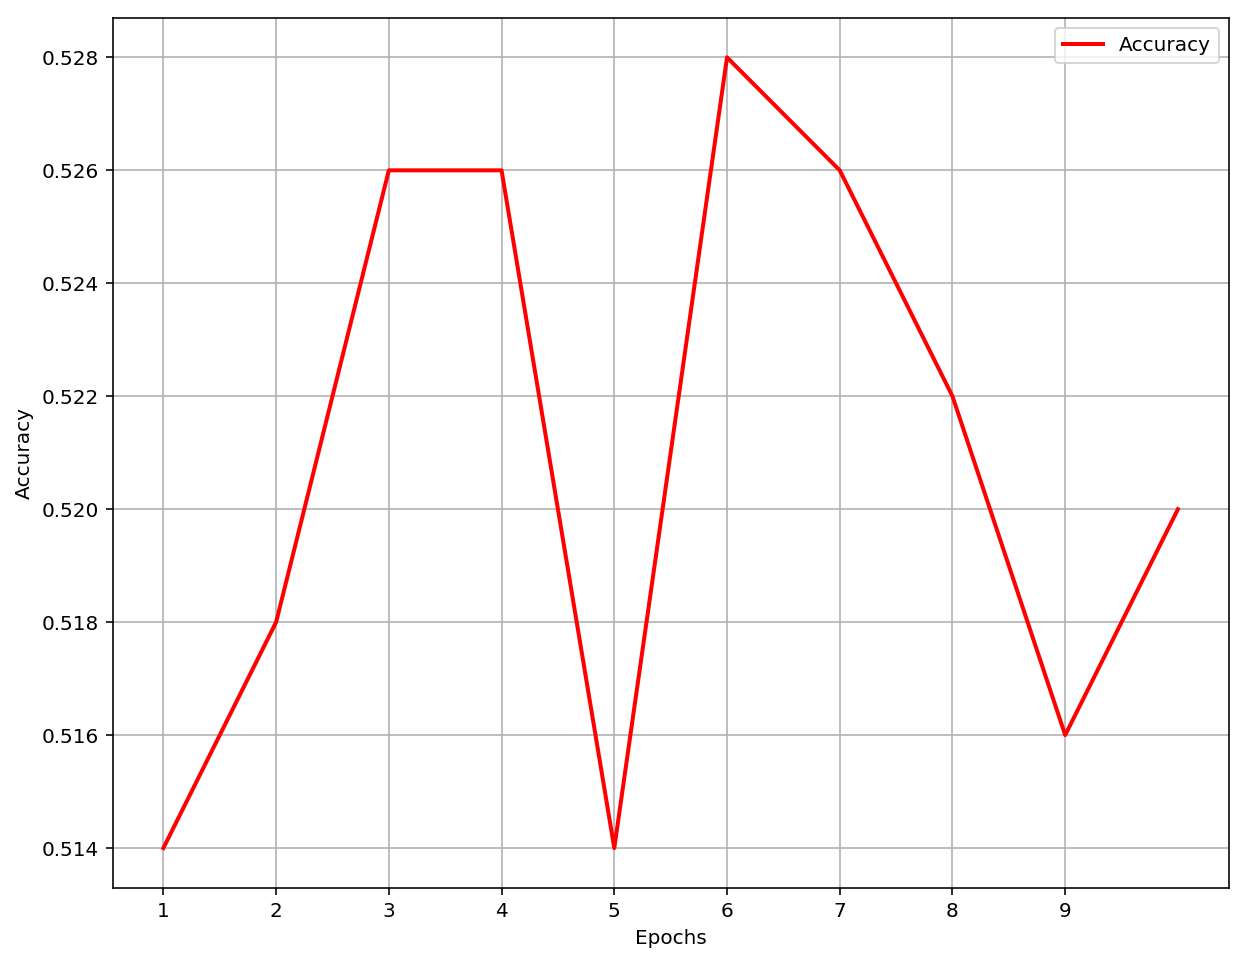

In [239]:
ACC = test(filename_list, devSeq1, devSeq2, label, show=False)

In [240]:
ACC

[0.514, 0.518, 0.526, 0.526, 0.514, 0.528, 0.526, 0.522, 0.516, 0.52]

In [242]:
compute(os.path.join(DATA_DIR, 'weights.010-4.971494.hdf5'), devSeq1, devSeq2, label)

100%|██████████| 500/500 [01:50<00:00,  4.45it/s]

Accuracy: 	0.514


0.514

In [244]:
compute('/Users/lizhn7/Downloads/EXPERIMENT/COPA/LM/cp_logs/weights.004-4.952414.hdf5', devSeq1, devSeq2, label)

100%|██████████| 500/500 [03:00<00:00,  2.70it/s]

Accuracy: 	0.512


0.512